In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
from tqdm import tqdm
from igraph import Graph

import sys
sys.path.append("../")
#from utils.reinforcement_learning.dqn_HD import DQN
from utils.reinforcement_learning.dqn import DQN
from utils.params import Params
from utils.evaluation.evaluationhelper import EvaluateModel
from utils.validation import get_Validation, area_under_curve
from utils.environment.game import GraphGame
from utils.environment.envhelper import reset
from utils.reinforcement_learning.rl_environment import Environment


def input_graph(graph_path,file):
    GRAPH = Graph.Read_Ncol(graph_path+str(file)+".txt", directed=False)
    nodes = [v.index for v in GRAPH.vs]
    map = {n:int(i) for i, n in enumerate(nodes)}
    GRAPH = reset(GRAPH)  
    Graph.simplify(GRAPH)
    return GRAPH, map


def CV_evaluation(graph_path, model_path,filename, parameter_path):  
    params = Params(parameter_path)
    file_list = []
    AUC = []
    x_label = []
    start = int(params.save_every)
    end = int(params.num_train_episodes)+start
    interval = int(params.save_every)
    for iteration in np.arange(start,end,interval):
        name = model_path+str(iteration)
        model = torch.load(name)
        auc_individual = []
        for file in filename:
            GRAPH, _ = input_graph(graph_path,file)
            N = GRAPH.vcount()
            game = GraphGame
            env = Environment(game)
            attacker = DQN(state_representation_size=params.centrality_features,
                            hidden_layers_sizes= params.hidden_layers,
                           global_feature_size =params.global_features)
            attacker._q_network.load_state_dict(model["_q_network"])
            attacker._optimizer.load_state_dict(model["_optimizer"])
            rewards, lcc, actions = EvaluateModel(env, attacker,GRAPH)
            #Compute Area under the curve
            x =  np.flip(np.arange(N)[N:0:-1]/N)
            auc_individual.append(area_under_curve(x[:len(lcc)],lcc))
        AUC.append(np.mean(auc_individual))
        x_label.append(iteration)
    AUC = np.array(AUC)
    x_label = np.array(x_label)
    return x_label, AUC

# Results

In [ ]:
model_path = ["../model/DiffSize_BA_Graph_TS/model_BAGraph_","../model/DiffSize_Different_Graph_TS/model_differentGraph_"]
parameters = ["../utils/ba_params.json","../utils/mixed_params.json"]
results = []
for path in tqdm(range(2)):
    graph_path ="../Dataset/Validation/GNNexplanation/"
    #filename = ['ba_300_20_house_1', 'ba_300_40_house_2', 'ba_300_60_house_3', 'ba_300_80_house_4', 'ba_300_100_house_5', 'ba_300_20_grid_1', 'ba_300_40_grid_2', 'ba_300_60_grid_3', 'ba_300_80_grid_4', 'ba_300_100_grid_5']
    filename = ['ba_300_20_house_1', 'ba_300_20_grid_1']
    x, ba = CV_evaluation(graph_path,model_path[path],filename,parameters[path])
    #filename = ['tree_8_20_cycle_1', 'tree_8_40_cycle_2', 'tree_8_60_cycle_3', 'tree_8_80_cycle_4', 'tree_8_100_cycle_5', 'tree_8_20_grid_1', 'tree_8_40_grid_2', 'tree_8_60_grid_3', 'tree_8_80_grid_4', 'tree_8_100_grid_5']
    filename = ['tree_8_20_cycle_1', 'tree_8_20_grid_1']
    x,tree = CV_evaluation(graph_path,model_path[path],filename,parameters[path])
    results.append([ba,tree])


  0%|                                                     | 0/2 [00:00<?, ?it/s]

In [ ]:
def lowest_AUC(x, CV_1, CV_2):
    cond =True
    while cond:
        g_1 = np.argmin(CV_1)
        g_2 = np.argmin(CV_2)
        if g_1 != g_2:
            CV_1 = np.delete(CV_1, g_1)
            CV_2 = np.delete(CV_2, g_2)
            x = np.delete(x, g_1)
        else:
            return x[g_1]
        
def lowest_AUC_each(x, CV_1, CV_2):
    g1 = np.argmin(CV_1)
    g2 = np.argmin(CV_2)
    return x[g1], x[g2]
        
results = np.array(results)
save_every= 500            
num_train_episodes = int(5e5) 
x = np.arange(500,num_train_episodes+save_every,save_every)
print(results.shape)
print("BA Graph")
print(lowest_AUC(x, results[0,0,0:int(num_train_episodes/save_every)], results[0,1,0:int(num_train_episodes/save_every)]))
print(lowest_AUC_each(x, results[0,0,0:int(num_train_episodes/save_every)], results[0,1,0:int(num_train_episodes/save_every)]))
print("Different Graph")
print(lowest_AUC(x, results[1,0,0:int(num_train_episodes/save_every)],results[1,1,0:int(num_train_episodes/save_every)]))
print(lowest_AUC_each(x, results[1,0,0:int(num_train_episodes/save_every)],results[1,1,0:int(num_train_episodes/save_every)]))



In [ ]:
for i in range(2):
    for j in range(2):
        if j == 0:
            color = 'blue'
            label = 'BA_Test'
            inv = 'red'
        else:
            color = 'red'
            label = 'Tree_Test'
            inv = 'blue'
        if i == 0:
            name = "(Trained Attacker [BA Model])"
            save = "BA"
        else:
            name = "(Trained Attacker [Mixed Model])"
            save = "Diff"
        min_value = np.argmin(results[i,j,0:int(num_train_episodes/save_every)])
        min_vc = x[min_value]
        #print(x[np.argsort(results[i,j,0:int(num_train_episodes/save_every)])])
        plt.plot(x, results[i,j,0:int(num_train_episodes/save_every)], color)
        plt.plot(min_vc, results[i,j,min_value], marker="o", markersize=5, markeredgecolor=inv, markerfacecolor="None",label="Min: "+str(min_vc))
        plt.title("AUC of LCC vs Nodes Plot "+""+str(name))
        plt.legend()
        print(label+"_"+save)
        plt.savefig("./Figure/Validation/eval_"+label+"_"+save)
        plt.show()

        
    sum_both = np.mean([results[0,0,0:int(num_train_episodes/save_every)],results[0,1,0:int(num_train_episodes/save_every)]],axis=0)
plt.plot(x, sum_both, color='green',label='Avg of Both')
min_value = np.argmin(sum_both)
min_vc = x[min_value]
plt.plot(min_vc, sum_both[min_value], marker="o", markersize=5, markeredgecolor='orange', markerfacecolor="None",label="Min: "+str(min_vc))
plt.title('Trained Attacker [BA Model]')
plt.legend()
plt.savefig("./Figure/Validation/eval_Homogenity_BA")
plt.show()
sum_both = np.mean([results[1,0,0:int(num_train_episodes/save_every)],results[1,1,0:int(num_train_episodes/save_every)]],axis=0)
plt.plot(x, sum_both, color='green',label='Avg of Both')
min_value = np.argmin(sum_both)
min_vc = x[min_value]

plt.plot(min_vc, sum_both[min_value], marker="o", markersize=5, markeredgecolor='orange', markerfacecolor="None",label="Min: "+str(min_vc))
plt.title('Trained Attacker [Diff Model]')
plt.legend()
plt.savefig("./Figure/Validation/eval_Homogenity_Mixed")
plt.show()
        

# Corruption Dataset

In [3]:
model_path = ["../model/DiffSize_BA_Graph_TS/model_BAGraph_","../model/DiffSize_Different_Graph_TS/model_differentGraph_"]
parameters = ["../utils/ba_params.json","../utils/mixed_params.json"]
corruption_auc = []
for path in tqdm(range(2)):
    graph_path ="../Dataset/Real/"
    filename = ['corruption']
    x, cor_auc = CV_evaluation(graph_path,model_path[path],filename,parameters[path])
    corruption_auc.append([x,cor_auc])

100%|█████████████████████████████████████████| 2/2 [5:09:09<00:00, 9274.54s/it]


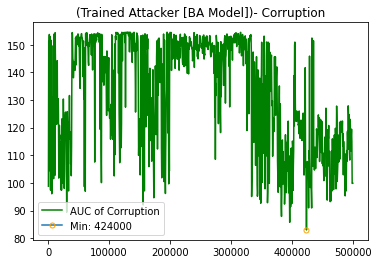

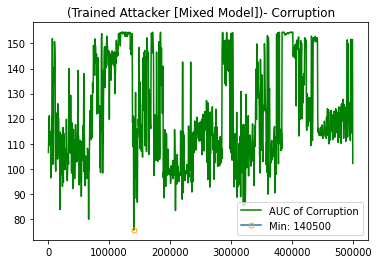

In [4]:
for i in range(len(corruption_auc)):
    if i == 0:
            name = "(Trained Attacker [BA Model])"
            save = "BA"
    else:
            name = "(Trained Attacker [Mixed Model])"
            save = "Diff"
    x, corruption = corruption_auc[i]
    plt.plot(x, corruption, color='green',label='AUC of Corruption')
    min_value = np.argmin(corruption)
    min_vc = x[min_value]
    plt.plot(min_vc, corruption[min_value], marker="o", markersize=5, markeredgecolor='orange', markerfacecolor="None",label="Min: "+str(min_vc))
    plt.title(name+"- Corruption")
    plt.legend()
    plt.savefig("./Figure/Validation/Corruption_"+save)
    plt.show()


# Crime Dataset

In [5]:
model_path = ["../model/DiffSize_BA_Graph_TS/model_BAGraph_","../model/DiffSize_Different_Graph_TS/model_differentGraph_"]
parameters = ["../utils/ba_params.json","../utils/mixed_params.json"]
crime_auc = []
for path in tqdm(range(2)):
    graph_path ="../Dataset/Real/"
    filename = ['moreno_crime_projected']
    x, Mcrime_auc = CV_evaluation(graph_path,model_path[path],filename,parameters[path])
    crime_auc.append([x,Mcrime_auc])

  0%|                                                     | 0/2 [18:48<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
for i in range(len(crime_auc)):
    if i == 0:
            name = "(Trained Attacker [BA Model])"
            save = "BA"
    else:
            name = "(Trained Attacker [Mixed Model])"
            save = "Diff"
    x, crime = crime_auc[i]
    plt.plot(x, crime, color='green',label='AUC of Crime')
    min_value = np.argmin(crime)
    min_vc = x[min_value]
    plt.plot(min_vc, crime[min_value], marker="o", markersize=5, markeredgecolor='orange', markerfacecolor="None",label="Min: "+str(min_vc))
    plt.title(name+"- MorenoCrime")
    plt.legend()
    plt.savefig("./Figure/Validation/Crime_"+save)
    plt.show()


# FoodWeb Dataset

In [ ]:
model_path = ["../model/DiffSize_BA_Graph_TS/model_BAGraph_","../model/DiffSize_Different_Graph_TS/model_differentGraph_"]
parameters = ["../utils/ba_params.json","../utils/mixed_params.json"]
food_auc = []
for path in tqdm(range(2)):
    graph_path ="../Dataset/Real/"
    filename = ['foodweb-baywet']
    x, foods_auc = CV_evaluation(graph_path,model_path[path],filename,parameters[path])
    food_auc.append([x,foods_auc])

In [ ]:
for i in range(len(food_auc)):
    if i == 0:
            name = "(Trained Attacker [BA Model])"
            save = "BA"
    else:
            name = "(Trained Attacker [Mixed Model])"
            save = "Diff"
    x, food = food_auc[i]
    plt.plot(x, food, color='green',label='AUC of FoodWeb')
    min_value = np.argmin(food)
    min_vc = x[min_value]
    plt.plot(min_vc, food[min_value], marker="o", markersize=5, markeredgecolor='orange', markerfacecolor="None",label="Min: "+str(min_vc))
    plt.title(name+"- FoodWeb")
    plt.legend()
    plt.savefig("./Figure/Validation/Food_"+save)
    plt.show()


# inf-USAir97 Dataset

In [ ]:
model_path = ["../model/DiffSize_BA_Graph_TS/model_BAGraph_","../model/DiffSize_Different_Graph_TS/model_differentGraph_"]
parameters = ["../utils/ba_params.json","../utils/mixed_params.json"]
USAir_auc = []
for path in tqdm(range(2)):
    graph_path ="../Dataset/Real/"
    filename = ['inf-USAir97']
    x, USAir_i_auc = CV_evaluation(graph_path,model_path[path],filename,parameters[path])
    USAir_auc.append([x,USAir_i_auc])

In [ ]:
for i in range(len(USAir_auc)):
    if i == 0:
            name = "(Trained Attacker [BA Model])"
            save = "BA"
    else:
            name = "(Trained Attacker [Mixed Model])"
            save = "Diff"
    x, USAir = USAir_auc[i]
    plt.plot(x, USAir, color='green',label='AUC of USAir')
    min_value = np.argmin(USAir)
    min_vc = x[min_value]
    plt.plot(min_vc, USAir[min_value], marker="o", markersize=5, markeredgecolor='orange', markerfacecolor="None",label="Min: "+str(min_vc))
    plt.title(name+"- USAir97")
    plt.legend()
    plt.savefig("./Figure/Validation/USAir_"+save)
    plt.show()
